In [1]:
from pymarketng.application.Mechanism import *
from pymarketng.application.Utils import *
from pymarketng.application.BidManager import BidManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph

from pymarketng.domain.Bid import Bid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from typing import Callable, List, Type


### Load Dataset

In [2]:
raw_df = pd.read_csv('final_df (6).csv')
raw_df

,time,type_user0,load_user0,generate_user0,SOC_user0,unit_user0,price_user0,is_seller_user0,is_peak_user0,type_user1,...,type_user28,load_user28,unit_user28,price_user28,is_peak_user28,type_user29,load_user29,unit_user29,price_user29,is_peak_user29
0,4/5/2013 0:00,3,401,0.0,0.000000,401.000000,5613.044491,False,False,3,...,1,1163,1163,13327.052220,False,1,1614,1614,21002.425830,False
1,4/5/2013 1:00,3,374,0.0,0.000000,374.000000,5022.044440,False,False,3,...,1,635,635,7845.847922,False,1,564,564,6726.283197,False
2,4/5/2013 2:00,3,511,0.0,0.000000,511.000000,6492.803177,False,False,3,...,1,643,643,7787.924222,False,1,485,485,6212.153435,False
3,4/5/2013 3:00,3,370,0.0,0.000000,370.000000,5273.012858,False,False,3,...,1,485,485,5724.719719,False,1,611,611,7960.583553,False
4,4/5/2013 4:00,3,281,0.0,0.000000,281.000000,3994.521986,False,False,3,...,1,676,676,8442.209257,False,1,556,556,7441.749257,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4/7/2013 19:00,3,634,0.0,3.197569,0.000000,0.000000,NaN,True,3,...,1,552,552,6237.600000,True,1,815,815,12697.108340,True
68,4/7/2013 20:00,3,855,0.0,0.000000,791.048616,10937.166560,False,True,3,...,1,624,624,9679.777315,True,1,1962,1962,26699.634990,True
69,4/7/2013 21:00,3,1329,0.0,0.000000,1329.000000,21370.320000,False,True,3,...,1,766,766,9318.457839,True,1,1196,1196,15202.396210,True
70,4/7/2013 22:00,3,922,0.0,0.000000,922.000000,11495.884350,False,False,3,...,1,724,724,10103.640470,False,1,919,919,10450.549020,False


In [3]:
# Converting the shape of df to a simpler form (creating all_bids df)
number_of_users = len([col for col in raw_df.columns if col.startswith('type')])
new_list=[]
for i in range(number_of_users):
    bid = {
        "time":raw_df['time'],
        "is_peak":raw_df[f'is_peak_user{i}'],
        "load":raw_df[f'load_user{i}'],
        "generate":raw_df[f'generate_user{i}'] if f'generate_user{i}' in raw_df.columns else None,
        "SOC":raw_df[f'SOC_user{i}'] if f'SOC_user{i}' in raw_df.columns else None,
        "unit":raw_df[f'unit_user{i}'],
        "price":raw_df[f'price_user{i}'],
        "is_seller":raw_df[f'is_seller_user{i}'] if f'is_seller_user{i}' in raw_df.columns else False,
        "user": i,
        "user_type": raw_df[f'type_user{i}']
    }
    new_list.append(pd.DataFrame(bid))
df = pd.concat(new_list)

# parsing the time
df['time'] = pd.to_datetime(df['time'])

# calculate price per unit
df['price'] = df['price'] / df['unit'] 

df

/tmp/ipykernel_1067981/3436444265.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(new_list)


,time,is_peak,load,generate,SOC,unit,price,is_seller,user,user_type
0,2013-04-05 00:00:00,False,401,0.0,0.0,401.0,13.997617,False,0,3
1,2013-04-05 01:00:00,False,374,0.0,0.0,374.0,13.427926,False,0,3
2,2013-04-05 02:00:00,False,511,0.0,0.0,511.0,12.706073,False,0,3
3,2013-04-05 03:00:00,False,370,0.0,0.0,370.0,14.251386,False,0,3
4,2013-04-05 04:00:00,False,281,0.0,0.0,281.0,14.215381,False,0,3
...,...,...,...,...,...,...,...,...,...,...
67,2013-04-07 19:00:00,True,815,NaN,NaN,815.0,15.579274,False,29,1
68,2013-04-07 20:00:00,True,1962,NaN,NaN,1962.0,13.608377,False,29,1
69,2013-04-07 21:00:00,True,1196,NaN,NaN,1196.0,12.711034,False,29,1
70,2013-04-07 22:00:00,False,919,NaN,NaN,919.0,11.371653,False,29,1


In [44]:
# split sellers and buyers to different dataframes
buyers_df = df[df['is_seller'] == False]
sellers_df = df[df['is_seller'] == True]

0      0
1      0
2      0
3      0
4      0
      ..
67    29
68    29
69    29
70    29
71    29
Name: user, Length: 1467, dtype: int64

In [7]:
time_list = df['time'].unique()
time_list

<DatetimeArray>
['2013-04-05 00:00:00', '2013-04-05 01:00:00', '2013-04-05 02:00:00',
 '2013-04-05 03:00:00', '2013-04-05 04:00:00', '2013-04-05 05:00:00',
 '2013-04-05 06:00:00', '2013-04-05 07:00:00', '2013-04-05 08:00:00',
 '2013-04-05 09:00:00', '2013-04-05 10:00:00', '2013-04-05 11:00:00',
 '2013-04-05 12:00:00', '2013-04-05 13:00:00', '2013-04-05 14:00:00',
 '2013-04-05 15:00:00', '2013-04-05 16:00:00', '2013-04-05 17:00:00',
 '2013-04-05 18:00:00', '2013-04-05 19:00:00', '2013-04-05 20:00:00',
 '2013-04-05 21:00:00', '2013-04-05 22:00:00', '2013-04-05 23:00:00',
 '2013-04-06 00:00:00', '2013-04-06 01:00:00', '2013-04-06 02:00:00',
 '2013-04-06 03:00:00', '2013-04-06 04:00:00', '2013-04-06 05:00:00',
 '2013-04-06 06:00:00', '2013-04-06 07:00:00', '2013-04-06 08:00:00',
 '2013-04-06 09:00:00', '2013-04-06 10:00:00', '2013-04-06 11:00:00',
 '2013-04-06 12:00:00', '2013-04-06 13:00:00', '2013-04-06 14:00:00',
 '2013-04-06 15:00:00', '2013-04-06 16:00:00', '2013-04-06 17:00:00',
 '20

### Max and Min Price

In [8]:
Min_price_seller = sellers_df['price'].min()
Max_price_seller = sellers_df['price'].max()
Min_price_buyer = buyers_df[buyers_df['price'] > 0]['price'].min()
Max_price_buyer = buyers_df['price'].max()
print('Max_price_buyer:',Max_price_buyer)
print('Min_price_buyer',Min_price_buyer)
print('Max_price_seller:',Max_price_seller)
print('Min_price_seller',Min_price_seller)
P_fit = 0.05
p_G = 900

Max_price_buyer: 16.08
Min_price_buyer 11.299999999160564
Max_price_seller: 16.721150646922144
Min_price_seller 11.299999998359734


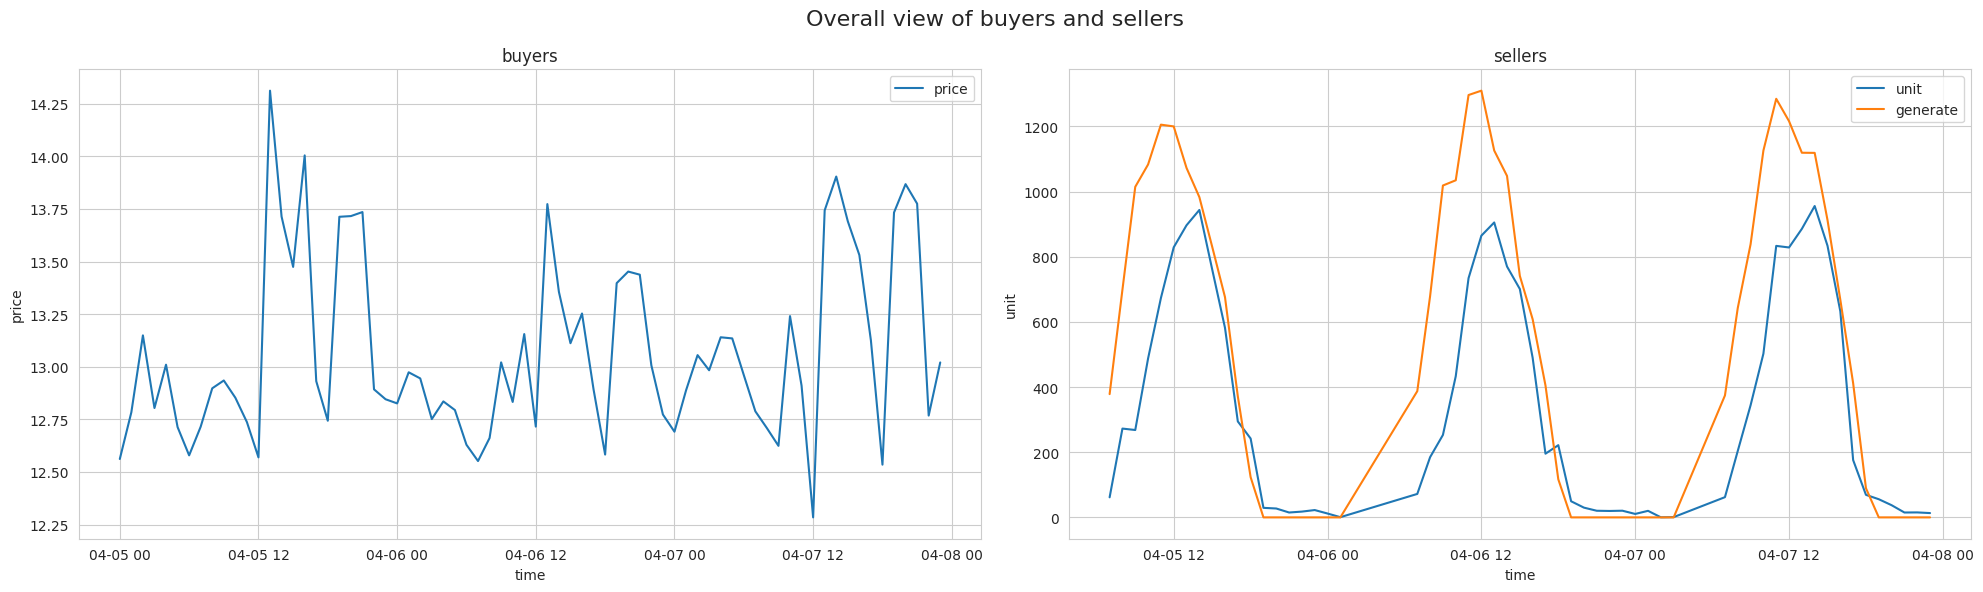

In [12]:
# TODO: move to lib
# TODO: needs update

# Overall view of sellers and buyers
sns.set_style("whitegrid")
# Create the plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Overall view of buyers and sellers', fontsize=16)

d = buyers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()
sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[0])
# sns.lineplot(data=d, x='time', y='unit', label='unit', ax=axs[0])
# sns.lineplot(data=d, x='time', y='generate', label='generate', ax=axs[0])
axs[0].set_title('buyers')
axs[0].legend()

d = sellers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()
# sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[1])
sns.lineplot(data=d, x='time', y='unit', label='unit', ax=axs[1])
sns.lineplot(data=d, x='time', y='generate', label='generate', ax=axs[1])
axs[1].set_title('sellers')
axs[1].legend()

plt.tight_layout()  # Adjust layout to make room for rotated labels

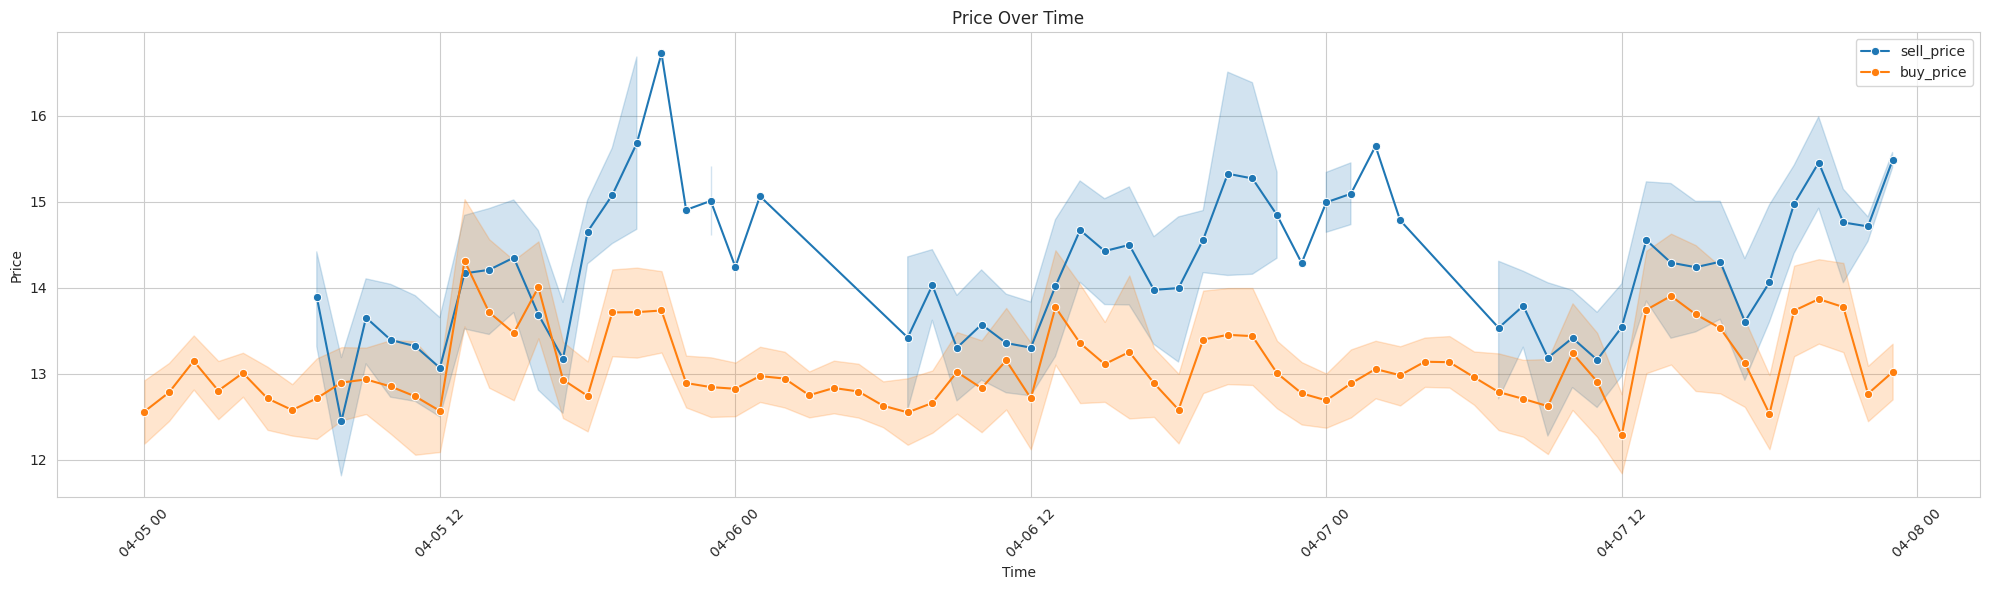

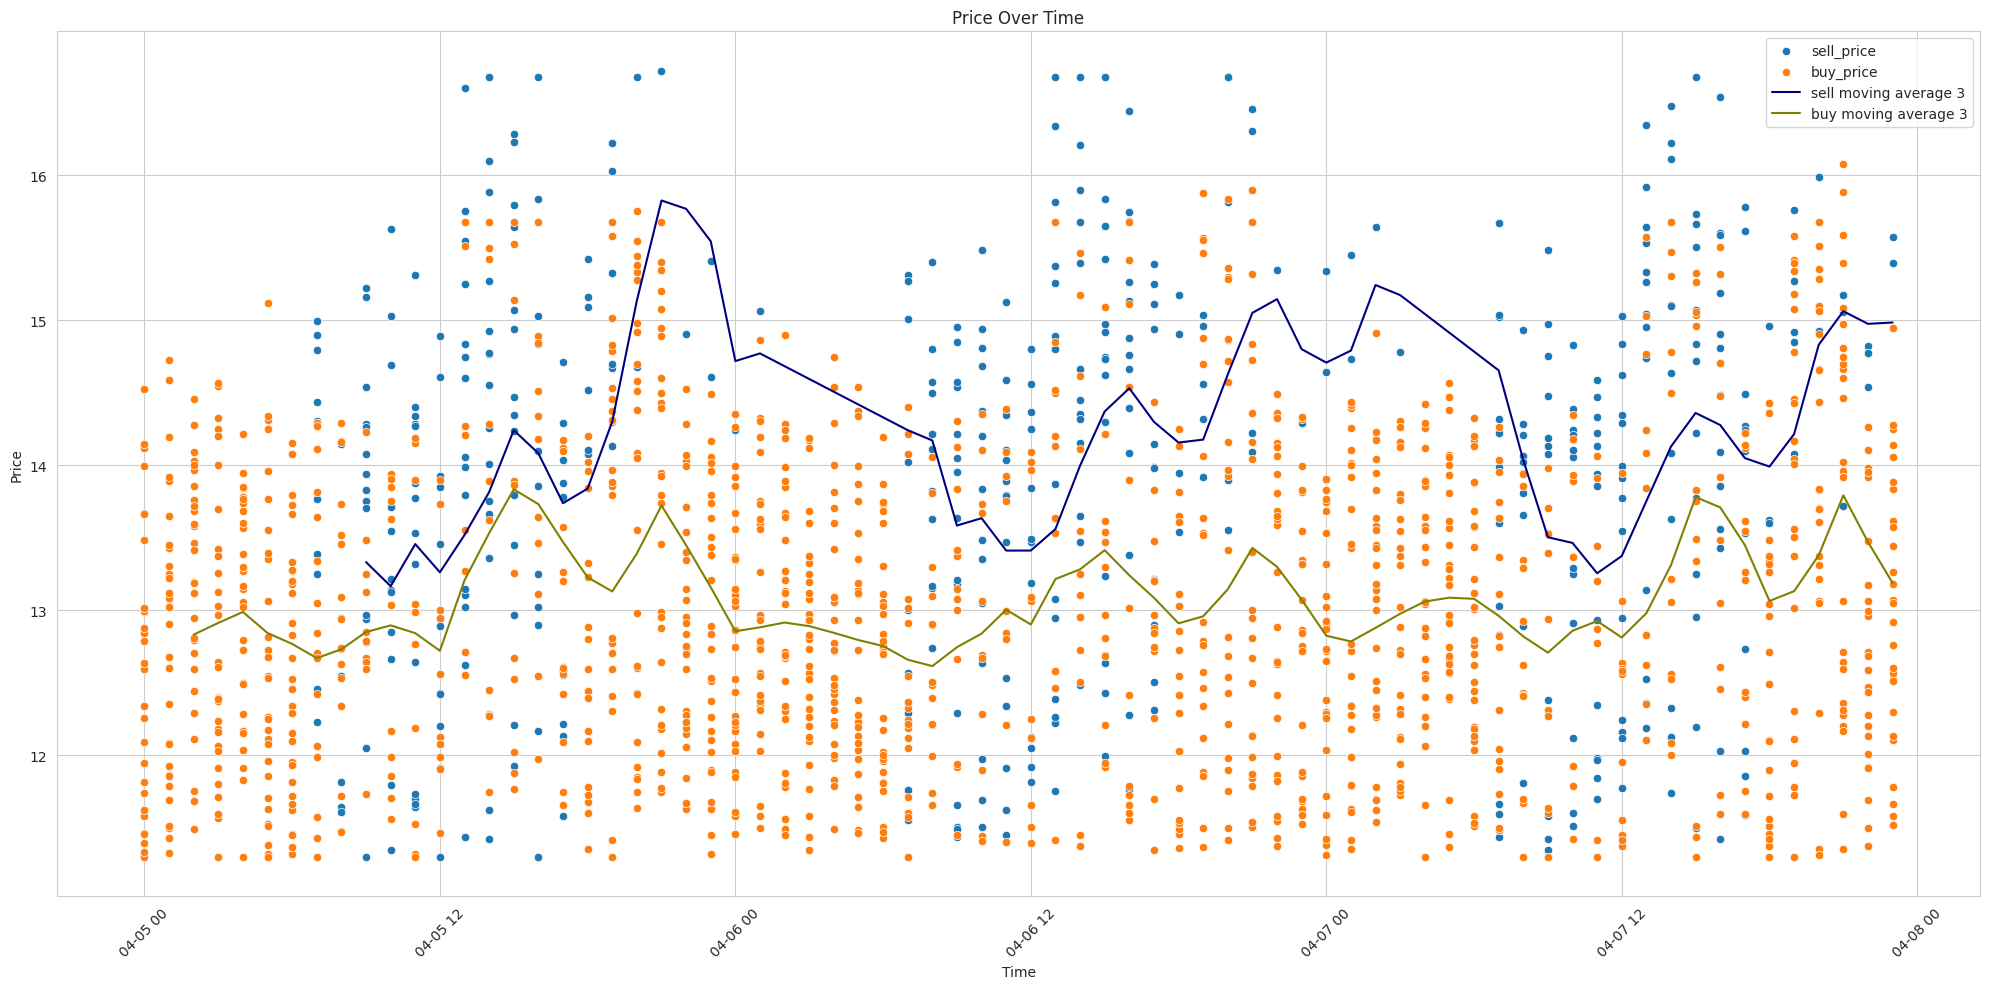

In [54]:
# TODO: move to library

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=sellers_df.reset_index(drop=True), x='time', y='price', marker='o', label='sell_price')
sns.lineplot(data=buyers_df.reset_index(drop=True), x='time', y='price', marker='o', label='buy_price')

# Add titles and labels
plt.title('Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()

# scatterplot
plt.figure(figsize=(20, 10))
sns.scatterplot(data=sellers_df.reset_index(drop=True), x='time', y='price',label='sell_price' , marker='o')
sns.scatterplot(data=buyers_df.reset_index(drop=True), x='time', y='price',label='buy_price' , marker='o')

# mean of price
window_size = 3
d = sellers_df.groupby('time').agg({'price': 'mean'}).reset_index()
sns.lineplot(data=d, x='time', y=d['price'].rolling(window=window_size).mean(),  label=f'sell moving average {window_size}', color='navy')
d = buyers_df.groupby('time').agg({'price': 'mean'}).reset_index()
sns.lineplot(data=d, x='time', y=d['price'].rolling(window=window_size).mean(),  label=f'buy moving average {window_size}', color='olive')

# Add titles and labels
plt.title('Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()


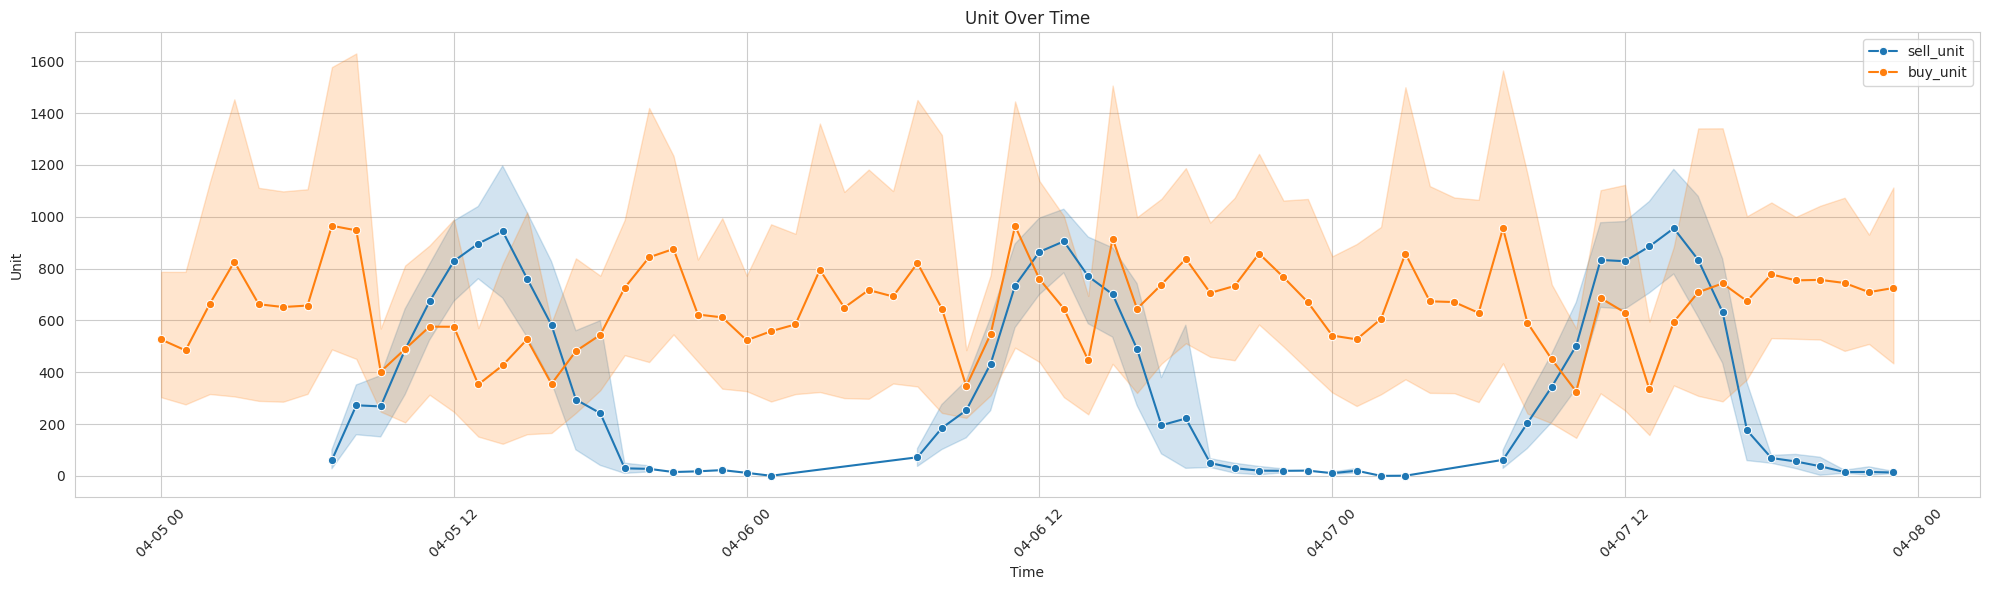

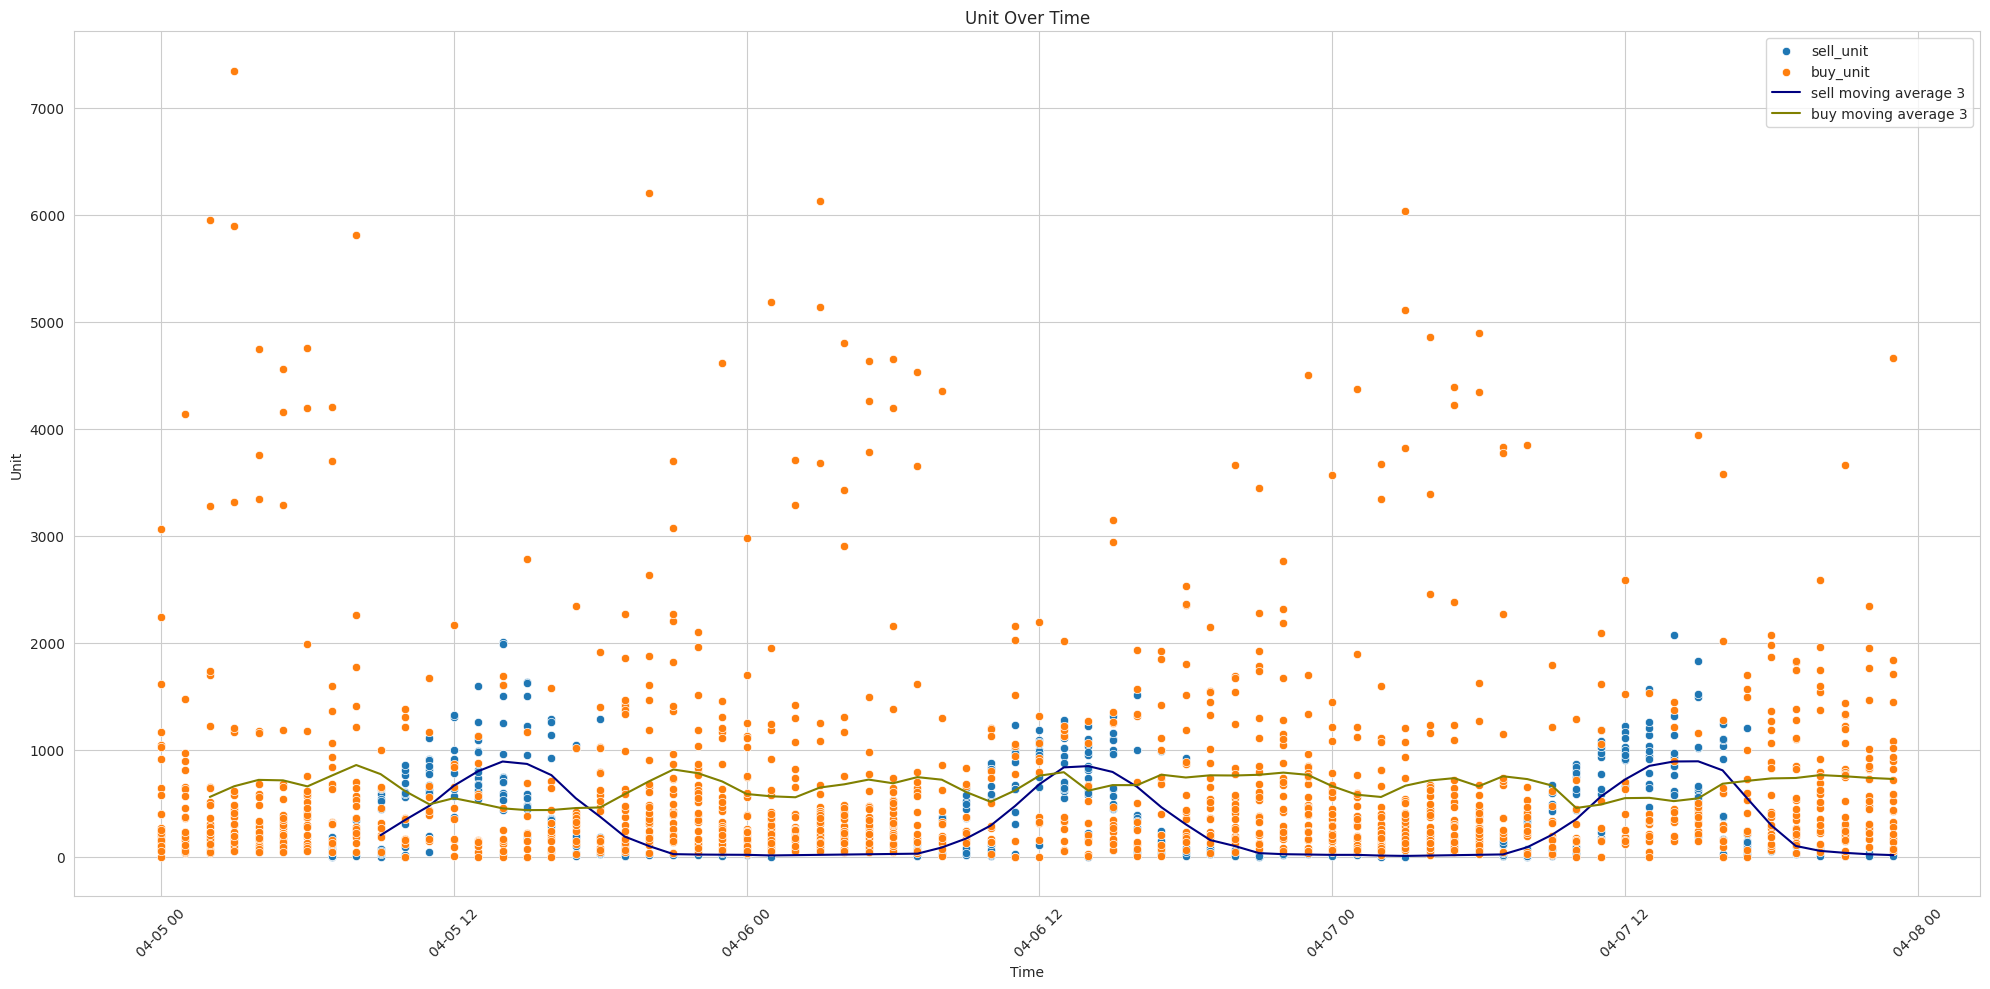

In [53]:
# TODO: move to library

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
sns.lineplot(data=sellers_df.reset_index(drop=True), x='time', y='unit', marker='o', label='sell_unit')
sns.lineplot(data=buyers_df.reset_index(drop=True), x='time', y='unit', marker='o', label='buy_unit')

# Add titles and labels
plt.title('Unit Over Time')
plt.xlabel('Time')
plt.ylabel('Unit')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()


# scatterplot
plt.figure(figsize=(20, 10))
sns.scatterplot(data=sellers_df.reset_index(drop=True), x='time', y='unit', marker='o', label='sell_unit')
sns.scatterplot(data=buyers_df.reset_index(drop=True), x='time', y='unit', marker='o', label='buy_unit')

# mean of unit
window_size = 3
d = sellers_df.groupby('time').agg({'unit': 'mean'}).reset_index()
sns.lineplot(data=d, x='time', y=d['unit'].rolling(window=window_size).mean(),  label=f'sell moving average {window_size}', color='navy')
d = buyers_df.groupby('time').agg({'unit': 'mean'}).reset_index()
sns.lineplot(data=d, x='time', y=d['unit'].rolling(window=window_size).mean(),  label=f'buy moving average {window_size}', color='olive')

# Add titles and labels
plt.title('Unit Over Time')
plt.xlabel('Time')
plt.ylabel('Unit')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()

In [55]:
# TODO: move to library
# TODO: we should use is_peak var in our df in our selection mechanism
# TODO: we need anomaly based on time cause the plot is like the heart beat.

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Select price and time features from df
buyers = df[['price', 'unit' ]]
# sellers = df[df['is_seller']==False][['price', 'time']]

# Standardize the data
buyers_normilized = pd.DataFrame(StandardScaler().fit_transform(buyers))
buyers_normilized


# Train OneClassSVM
model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
model.fit(buyers_normilized)
df['buyers_anomaly'] = pd.Series(model.predict(buyers_normilized))

# Plot anomalies
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
sns.scatterplot(data=buyers_df, x='time', y='price', marker='o', label='buy')
sns.scatterplot(data=df.loc[df['buyers_anomaly'] == -1], x='time', y='price', label='anomaly')
# # Add titles and labels
plt.title('Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# # Show the plot
plt.show()


ValueError: Input X contains NaN.
OneClassSVM does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

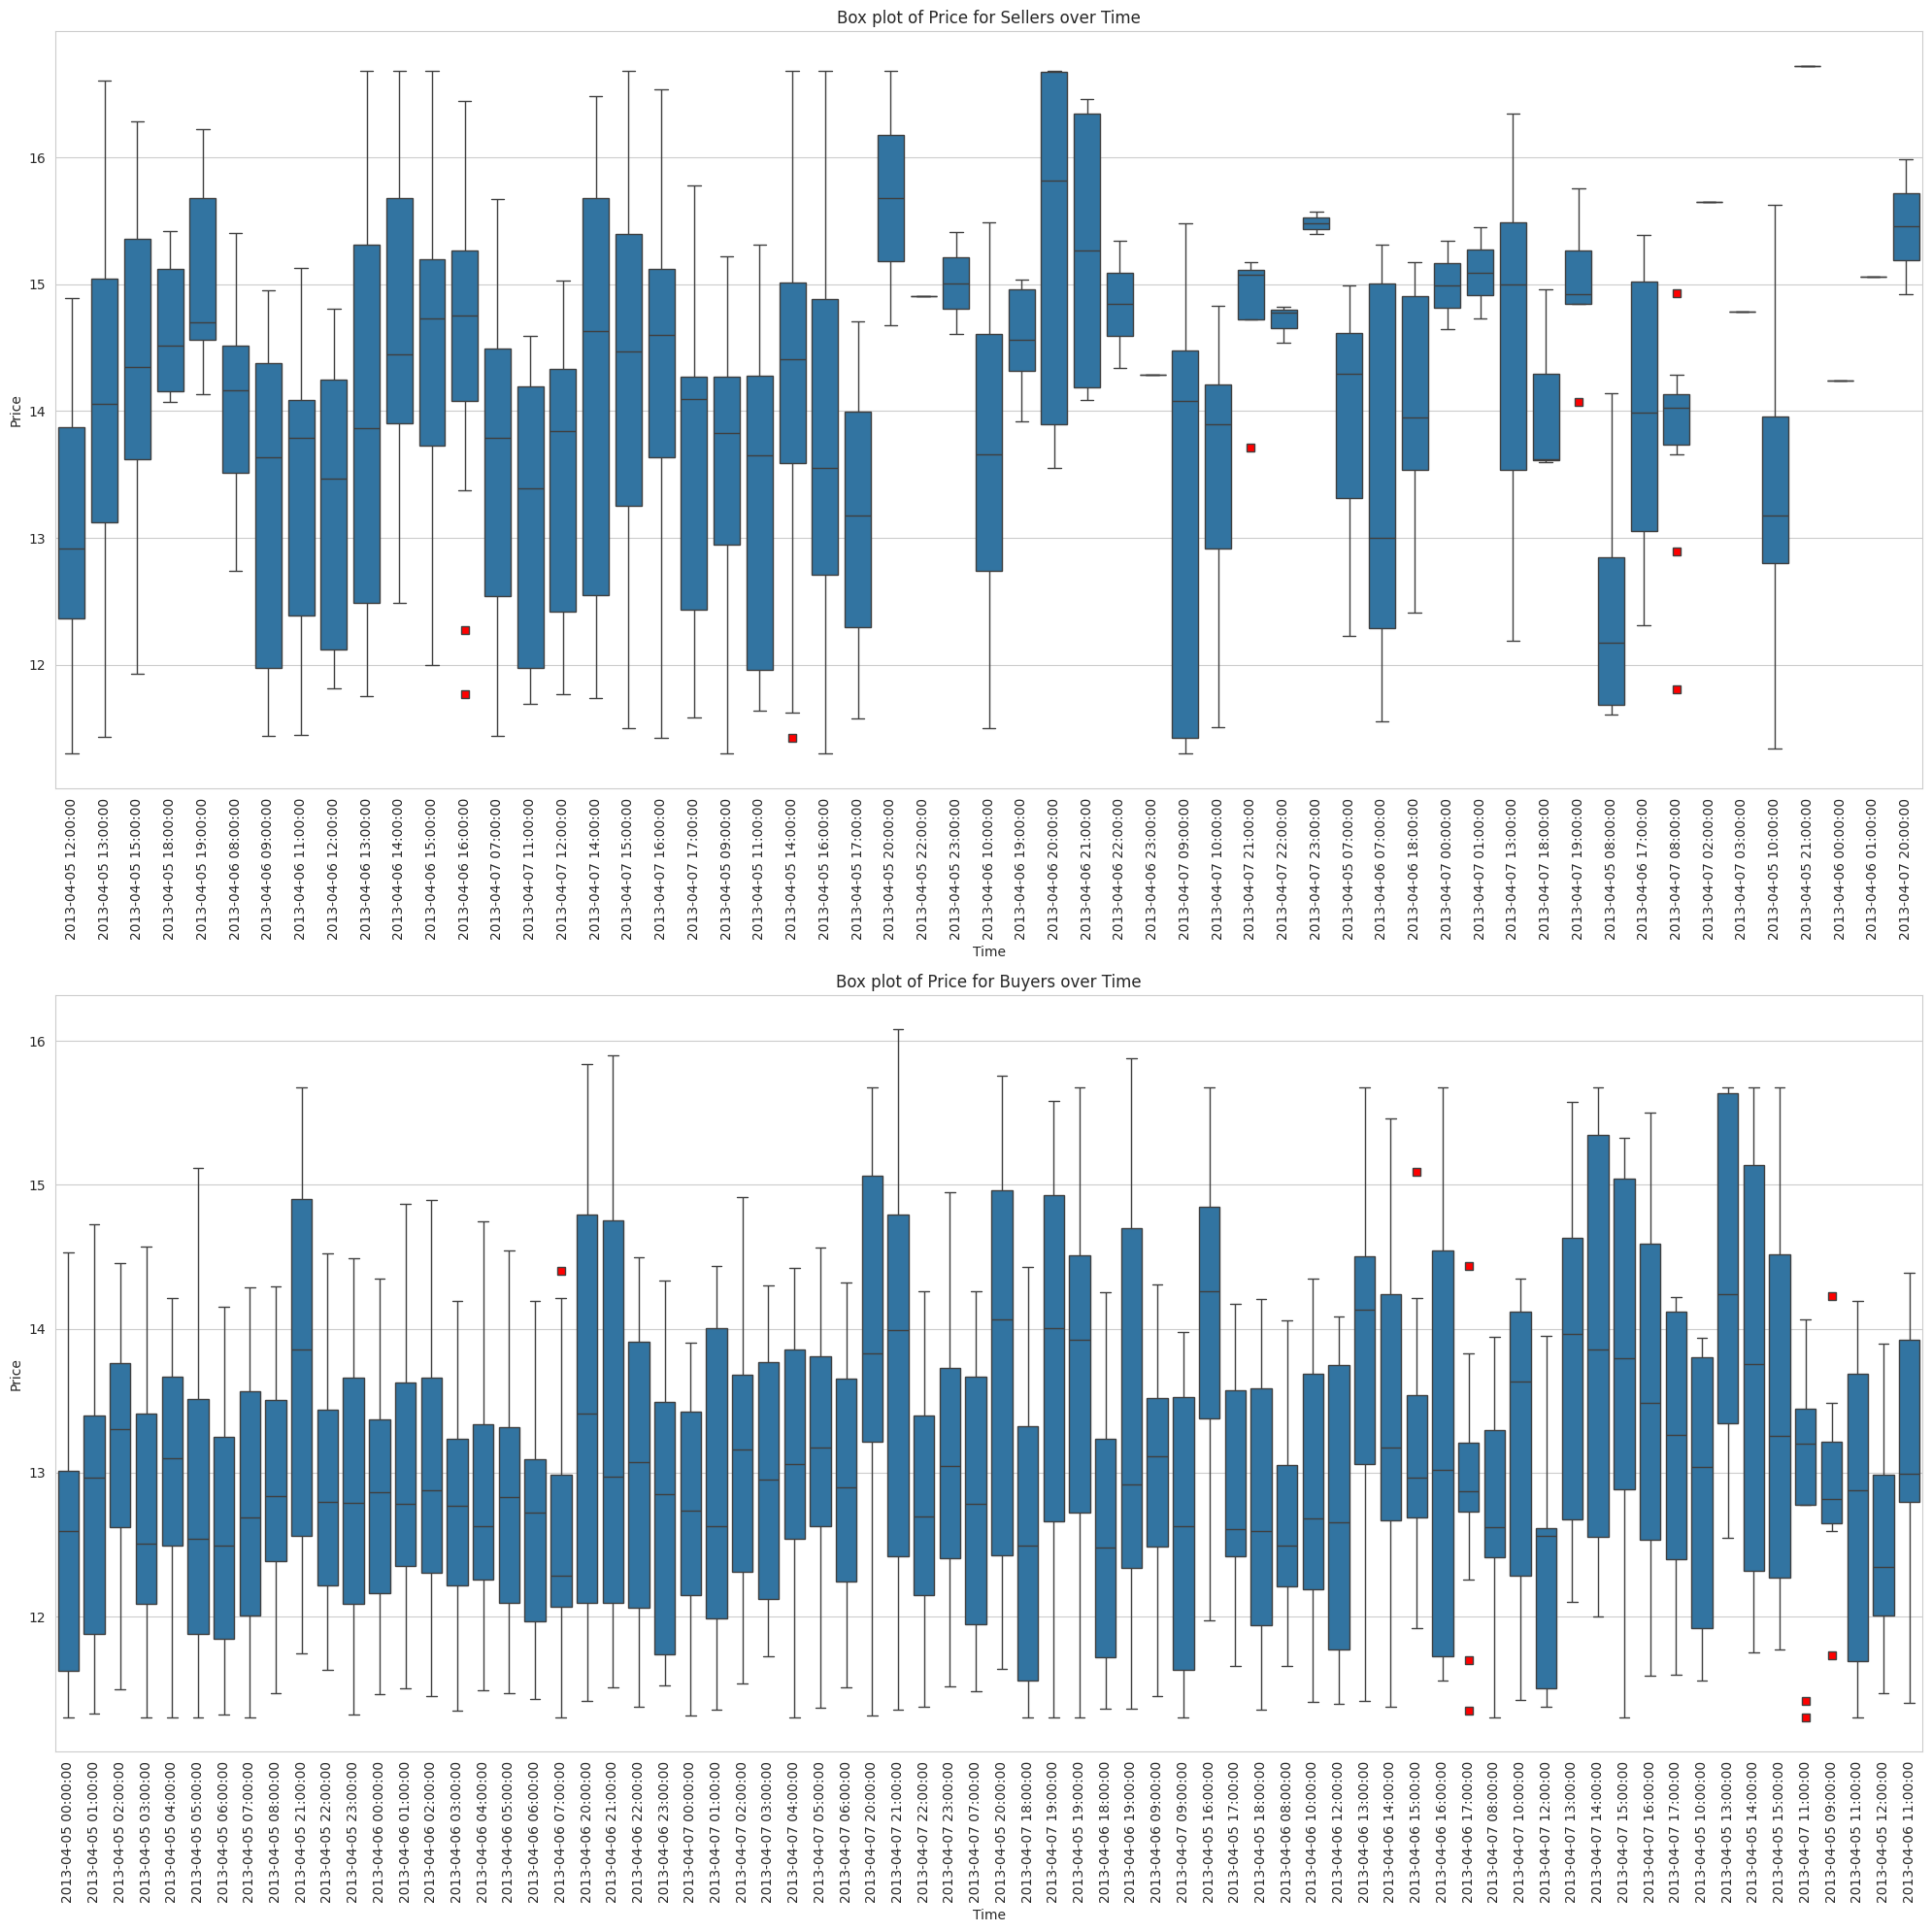

In [58]:
# TODO: move to library
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# Create a box plot for 'Price' for 'Seller' for each 'time'
sns.boxplot(x='time', y='price', data=sellers_df.reset_index(drop=True), ax=axes[0], flierprops=dict(markerfacecolor='r', marker='s'))
axes[0].set_title('Box plot of Price for Sellers over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Create a box plot for 'Price' for 'Buyer' for each 'time'
sns.boxplot(x='time', y='price', data=buyers_df.reset_index(drop=True), ax=axes[1], flierprops=dict(markerfacecolor='r', marker='s'))
axes[1].set_title('Box plot of Price for Buyers over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

# TODO: i guess we need to remove the outlirers and then we are able to calculate the mean. 

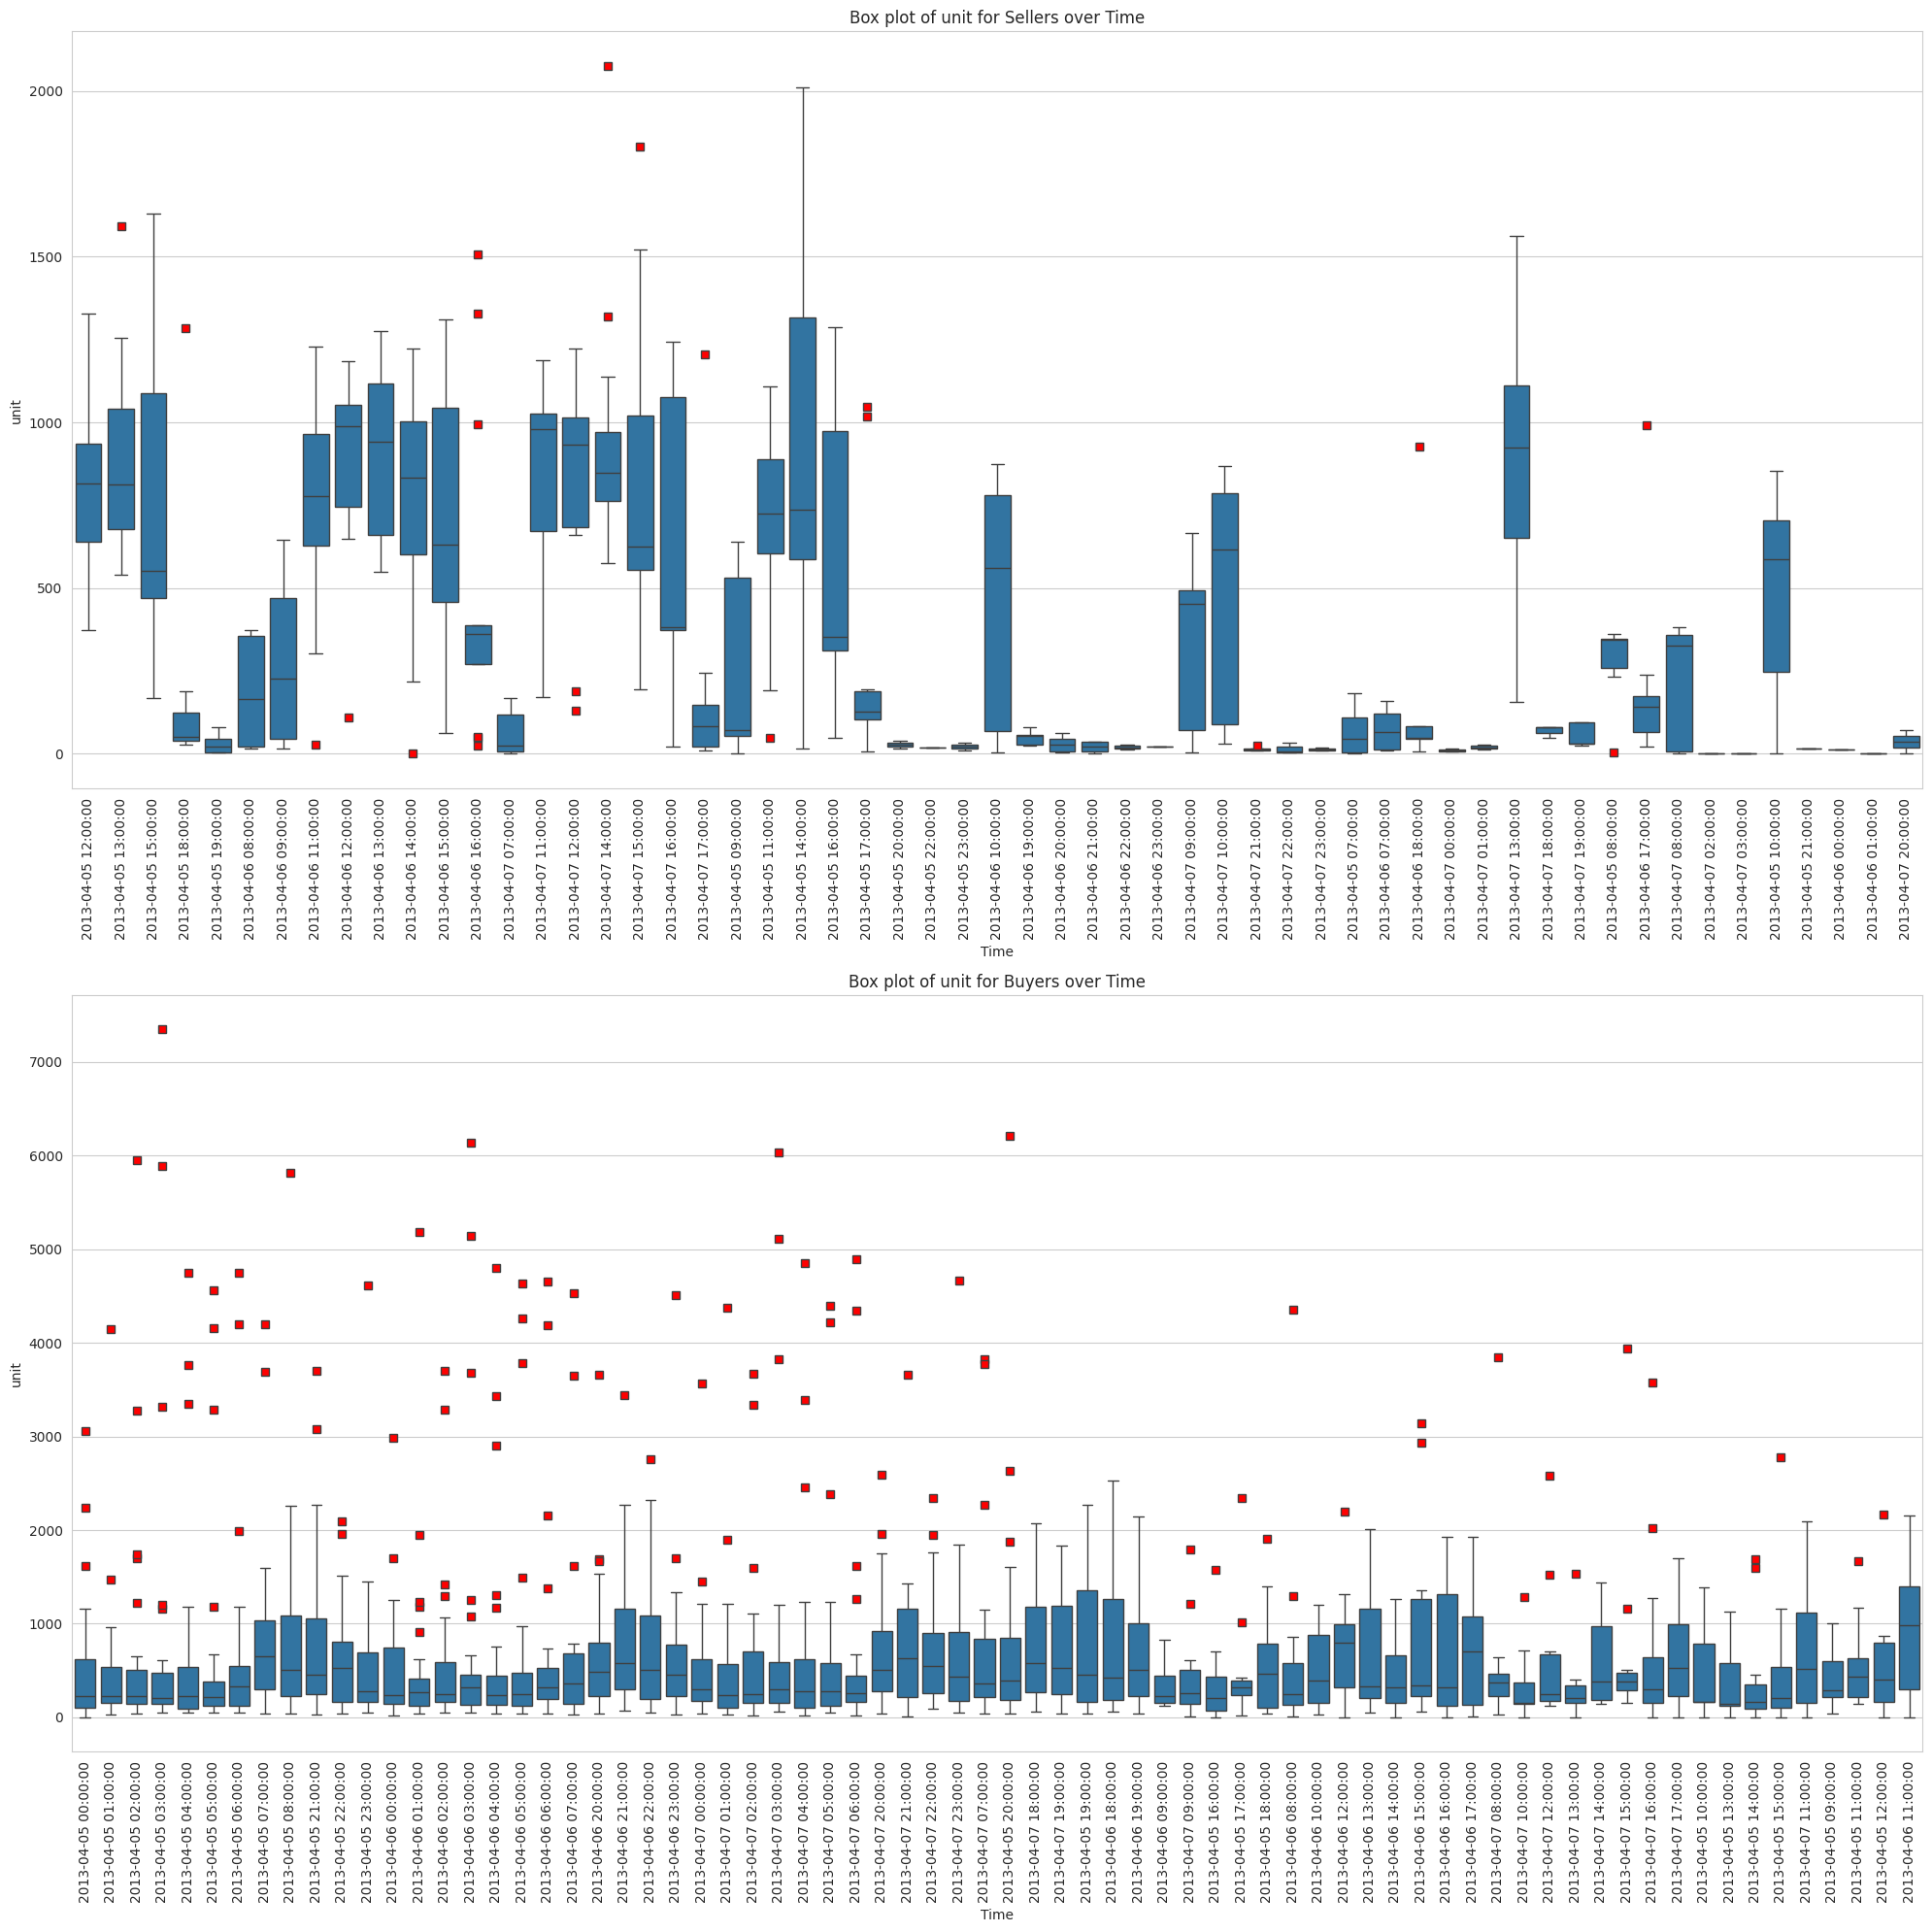

In [59]:
# TODO: move to library
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# Create a box plot for 'unit' for 'Seller' for each 'time'
sns.boxplot(x='time', y='unit', data=sellers_df.reset_index(drop=True), ax=axes[0], flierprops=dict(markerfacecolor='r', marker='s'))
axes[0].set_title('Box plot of unit for Sellers over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('unit')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Create a box plot for 'unit' for 'Buyer' for each 'time'
sns.boxplot(x='time', y='unit', data=buyers_df.reset_index(drop=True), ax=axes[1], flierprops=dict(markerfacecolor='r', marker='s'))
axes[1].set_title('Box plot of unit for Buyers over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('unit')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

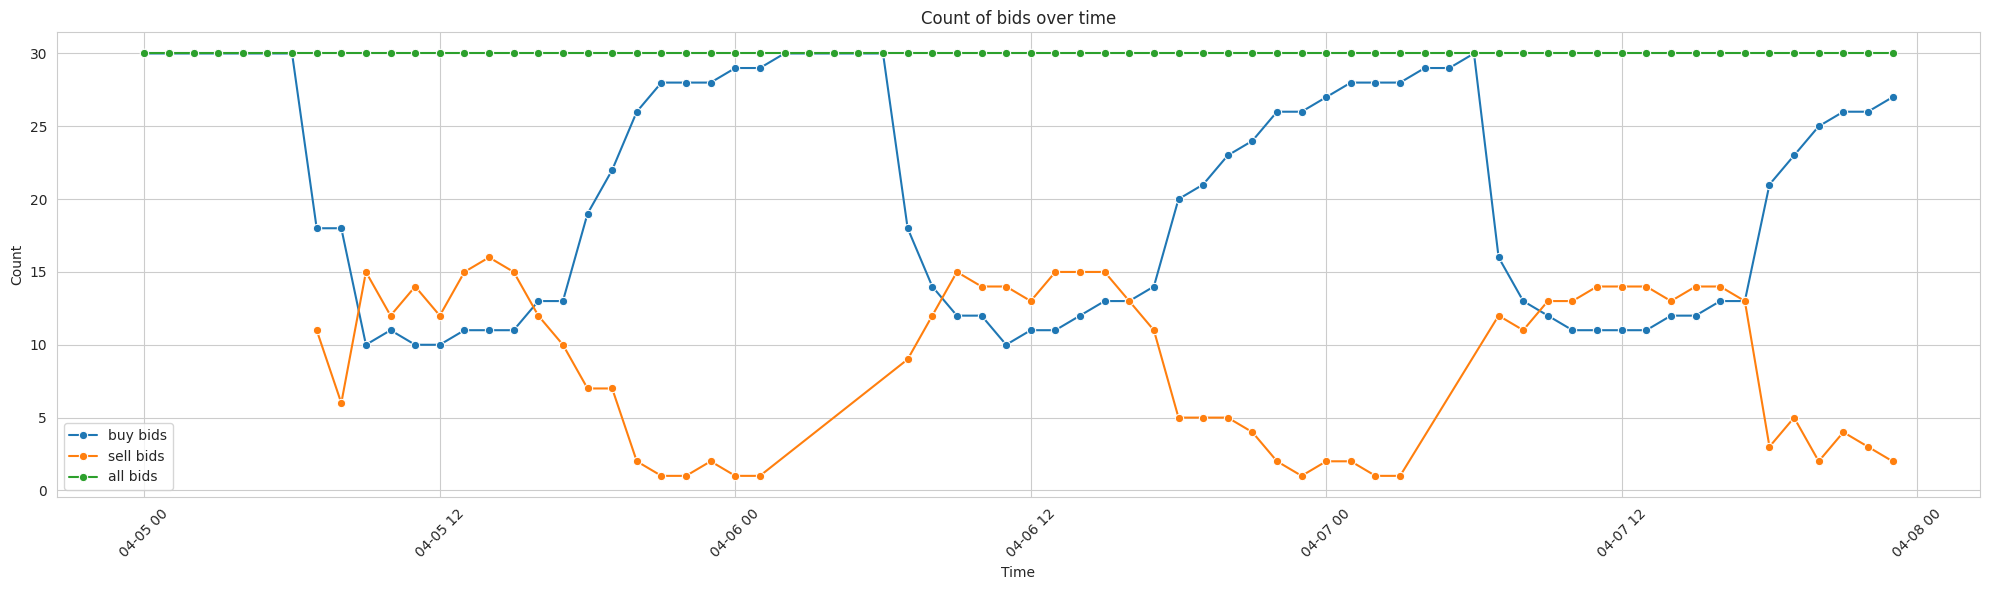

In [87]:
# TODO: move to library

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
buyers_bids_count = buyers_df.groupby('time').size().reset_index(name='count')
sellers_bids_count = sellers_df.groupby('time').size().reset_index(name='count')
all_bids_count = df.groupby('time').size().reset_index(name='count')
sns.lineplot(data=buyers_bids_count, x='time', y='count', marker='o', label='buy bids')
sns.lineplot(data=sellers_bids_count, x='time', y='count', marker='o', label='sell bids')
sns.lineplot(data=all_bids_count, x='time', y='count', marker='o', label='all bids')

# Add titles and labels
plt.title('Count of bids over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()

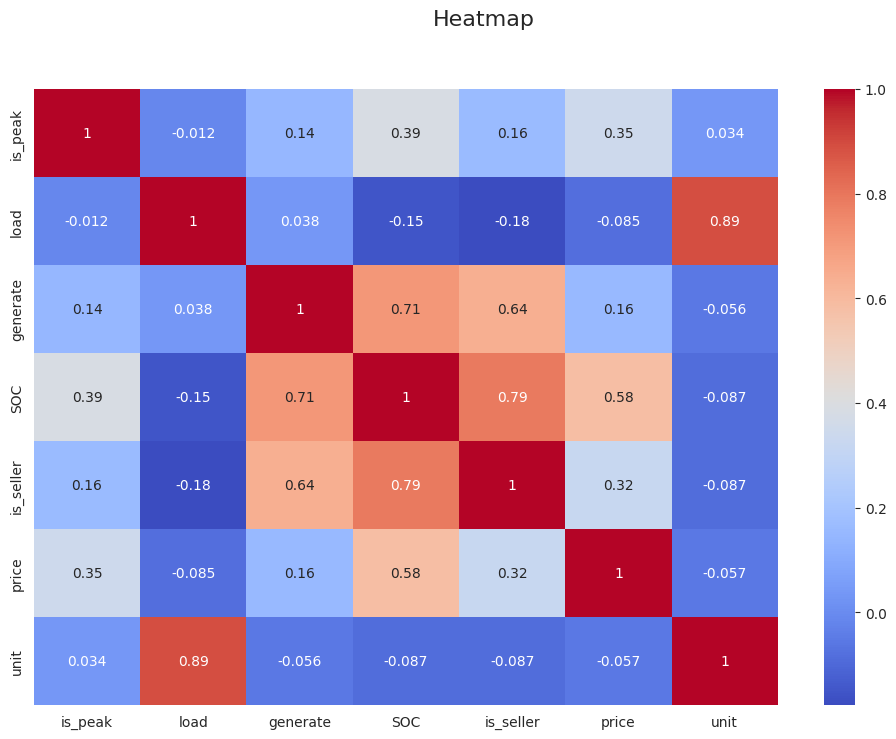

In [61]:
numerical_columns = ['is_peak', 'load', 'generate','SOC','is_seller', 'price', 'unit']
plt.figure(figsize=(12, 8))
plt.suptitle('Heatmap', fontsize=16)
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.show()

## Mechanism selection 

Our selection features:

1. number of participants (buyers/sellers/all) are low/high/neutral
2. buyers/sellers price or units are low/high/neutral
3. sellers units are higher/lower/equal to buyers
4. power of buyers and sellers regard together
3. we are in peak or not
4. number of outliers are low/high/neutral
5. anomaly detected based on the pattern of the each day plots (can detect outages caused by bad weathers)
6. profit of auctioneer
7. ...


- Z-score method
- Percentile method
- Statistical process control (SPC) charts
- Time-series decomposition
- Density estimation
- Anomaly detection algorithms
- Regression analysis
- Change point detection

### compare each round with its perivious round 

In [86]:
## TODO how can we calculate threshhold
alpha = 0.8
all_bids_count['count'].rolling(window=window_size).mean()

0      NaN
1      NaN
2     30.0
3     30.0
4     30.0
      ... 
67    30.0
68    30.0
69    30.0
70    30.0
71    30.0
Name: count, Length: 72, dtype: float64

### Calculate number of units

### Compare each number of units with its average from start to current round_time

In [16]:
## To Do how can we calculate threshhold
alpha_percent = 0.8
return_zero_if_negative = lambda x: 0 if x < 0 else x
moving_average_period=5
for i,round_time in enumerate(time_list):
    sum_previous_units = np.mean([sum['sum_units'] for sum in sum_unit_dict.values()][return_zero_if_negative(i-moving_average_period):i+1])
    print(sum_previous_units , i)
# sum_previous_units

13016.0 0
13172.5 1
15054.0 2
17215.25 3
17500.2 4
17644.333333333332 5
18583.5 6
19139.643278886666 7
18795.0205504115 8
15728.467744171501 9
13951.109725403168 10
12299.537560813165 11
10656.919159288167 12
13938.757293801498 13
13447.266867436667 14
14714.112841369999 15
14998.237596813335 16
14559.372798763334 17
14886.784305513333 18
12038.396146045001 19
13592.842634218332 20
15362.382799858335 21
16411.28272985 22
17928.71969249 23
18212.593253931667 24
17538.833333333332 25
16450.666666666668 26
16348.5 27
16743.0 28
17637.833333333332 29
18851.833333333332 30
18791.02149506167 31
17655.716257648335 32
14871.264476978335 33
13645.615631528335 34
12404.348877383336 35
11236.186524466664 36
14534.609285843331 37
15132.177487096667 38
17090.282587536665 39
17219.170590619997 40
17019.64340627 41
17948.313661124 42
14968.54434240233 43
15751.614711895667 44
16161.294725459002 45
17399.888901159 46
18199.516172987333 47
17354.674937716667 48
16891.166666666668 49
16554.833333333332 

## Normalized

## Weighting

In [18]:
values_lists = [NormalizeData(sum_units_list), NormalizeData(sum_participant_list), NormalizeData(diff_units_list)]


### Equal weighting

In [19]:
equal_weightings_Bool = False
weight_list = [1, 1, 1]
# we want to calculate the results by weighting the 
def equal_weightings(values_lists , weight_list, round):
    equal_output = sum([weight_list[i]*values_lists[i][round] for i in range(len(weight_list))])/len(weight_list)
    if equal_output > 0.2:
        equal_weightings_Bool = True
    else:
        equal_weightings_Bool =  False
                # print(direct_output, "The results are not within the expected range.")
    return equal_weightings_Bool

### Direct ranking

In [20]:
direct_ranking_Bool = False
weight_list = [0.5, 0.3, 0.2]
def direct_ranking(values_lists , weight_list):
    direct_output = sum([weight_list[i]*values_lists[i][round] for i in range(len(weight_list))])/len(weight_list)
    if direct_output > 0.2:
        direct_ranking_Bool = True
    else:
        direct_ranking_Bool =  False
                # print(direct_output, "The results are not within the expected range.")
    return direct_ranking_Bool

### Swing weighting

### Affordable for VCG

In [21]:
Beta = 0.7
def Is_Affordable(previous_auctioneer_profit , current_pay_vcg):
    if Beta*previous_auctioneer_profit > current_pay_vcg:
        return True
    else:
        return False

In [22]:
def mechanism_selctor_equal(
    bm_list: List[BidManager], tm_list: List[TransactionManager]
) -> Type[Mechanism]:
    previous_auctioneer_profit=0.0
    if len(tm_list) != 0:
        previous_auctioneer_profit=tm_list[-2].get_auctioneer_profit()
    incoming_round_vcg_auctioneer_profit=bm_list[-1].run(VCG_Mechanism_Multi)[1].get_auctioneer_profit()

    print(previous_auctioneer_profit, incoming_round_vcg_auctioneer_profit)
    if equal_weightings(values_lists, weight_list, len(tm_list)-1):
        return TradeReduction_Mechanism_Multi
    else:
        if Is_Affordable(previous_auctioneer_profit,incoming_round_vcg_auctioneer_profit):
            return VCG_Mechanism_Multi
        else:
            return Average_Mechanism_Multi

In [23]:
def mechanism_selctor_direct(
    bm_list: List[BidManager], tm_list: List[TransactionManager]
) -> Type[Mechanism]:
    previous_auctioneer_profit=0.0
    if len(tm_list) != 0:
        previous_auctioneer_profit=tm_list[-2].get_auctioneer_profit()
    incoming_round_vcg_auctioneer_profit=bm_list[-1].run(VCG_Mechanism_Multi)[1].get_auctioneer_profit()

    print(previous_auctioneer_profit, incoming_round_vcg_auctioneer_profit)
    if equal_weightings(values_lists, weight_list, len(tm_list)-1):
        return TradeReduction_Mechanism_Multi
    else:
        if Is_Affordable(previous_auctioneer_profit,incoming_round_vcg_auctioneer_profit):
            return VCG_Mechanism_Multi
        else:
            return Average_Mechanism_Multi

## Run Round

In [ ]:
bm=bm_list[18]
bm_new,tm= bm.run(TradeReduction_Mechanism_Multi)
tm.get_auctioneer_profit()

215.28103238209974